In [1]:
from __future__ import print_function

import os
import numpy as np
# import torch
# import pandas as pd
from io import StringIO
# from google.cloud import storage
import matplotlib.pyplot as plt#, mpld3
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
from scipy.misc import logsumexp
# Keras
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.metrics import binary_accuracy
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten
from keras.layers.core import Dense, Dropout, Activation, Layer, Lambda, Flatten
from keras.regularizers import l2
from keras.optimizers import RMSprop, Adadelta, adam
from keras.layers.advanced_activations import LeakyReLU
import random
seed = 0 #0
np.random.seed(seed=seed)
random.seed(seed)

%matplotlib inline
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../ab2.json"

Using TensorFlow backend.


# Load data from numpy arrays

In [2]:
def load_data_file(data_file, num_features):
    
    data = np.load(data_file)
    
    if data.ndim == 1:
        data = data[None, :]
    
    x = data[:, :num_features]
    y = data[:, num_features:]
    
    return x, y

In [3]:
num_features = 13
x_data, y_data = load_data_file(data_file='../../train/training_hela.npy', num_features=num_features)

In [4]:
Ntr = 70000
x_data_tr = x_data[:Ntr,:]
y_data_tr = y_data[:Ntr,:]
x_data_val = x_data[Ntr:,:]
y_data_val_un = y_data[Ntr:,:]

In [5]:
x_data.shape

(79999, 13)

# Training / Validation split

* Consider taking log 10 of data (Being careful not to take the log of the temperature features if they are included)

In [6]:
y_data.shape

(79999, 5)

In [7]:
# x_range = x_data.max(0) - x_data.min(0)
# y_range = y_data.max(0) - y_data.min(0)

## Normalise: remove mean and divide by standard deviation

In [8]:
# Normalise
x_data_tr = (x_data_tr - x_data.mean(0))/x_data.std(0)
x_data_val = (x_data_val - x_data.mean(0))/x_data.std(0)
# x_data_te = (x_data_te - x_data.mean(0))/x_data.std(0)

y_data_tr = (y_data_tr - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]
y_data_val = (y_data_val_un - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]
# y_data_te = (y_data_te - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]


# x_data_tr = (x_data_tr - x_data.min(0)) / ( x_range)
# x_data_val = (x_data_val - x_data.min(0)) / (x_range)

# y_data_tr = (y_data_tr - y_data.min(0)) / ( y_range)
# y_data_val = (y_data_val - y_data.min(0)) / (y_range)

In [9]:
x_data_tr = np.squeeze(x_data_tr)
x_data_val = np.squeeze(x_data_val)
# x_data_te = np.squeeze(x_data_te)

## For a CNN you need to add a channel at the end which is done in the cell below.
* If you want to use a FF NN, use the above cell and dont run the one below

In [10]:
# # CNN
# x_data_tr = np.expand_dims(x_data_tr,2)
# x_data_val = np.expand_dims(x_data_val,2)
# # x_data_te = np.expand_dims(x_data_val,2)

In [11]:
x_data_val.shape

(9999, 13)

In [12]:
y_data_val.shape

(9999, 5)

In [13]:
Early_Stop_acc = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
# units
units = 1024
batch_size = 256
epochs = 64

# nb_filter = 64
# filter_length = 5
def network(dropout,tau):
    # Regularise
    lengthscale = .01
    reg = lengthscale**2 * (1 - dropout) / (2. * Ntr * tau)
    model = Sequential()
    model.add(Dense(units, activation='relu'))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(units, activation='relu'))
              #     model.add(Dense(units, activation='relu', input_shape=x_data_tr.shape[1:],W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(units, activation='relu',W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(units, activation='relu',W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(units, activation='relu',W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
#     model.add(Dense(y_data_tr.shape[-1], activation='relu',W_regularizer=l2(reg)))
#     model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(y_data_tr.shape[-1], activation='linear',W_regularizer=l2(reg)))
    return model

In [14]:
class BNNModel:
    """
    Builds basic BNN model around training data
    """
    
    def __init__(self, X: np.array, Y: np.array, architecture: list, dropout = 0.1, T = 10, tau = 1.0, lengthscale = 1., base_lr = 5e-2, gamma = 0.0001*0.25):
        """
        :X: training data X -> so far only implemented for 1D data, needs to be of shape (n,1) or (1,n)
        :Y: training data y, needs to be passed as array of shape (n,1);
        :param architecture: list of perceptrons per layer, as long as network deep
        :param dropout: probability of perceptron being dropped out
        :param T: number of samples from posterior of weights during test time
        :param tau: precision of prior
        :param lengthscale: lengthscale
        :param base_lr: initial learning rate for SGD optimizer
        :param gamma: parameter for decay of initial learning rate according to default SGD learning schedule
        """
        if np.shape(X)[0] == len(Y):
            assert np.shape(X)[1] >= 1
        else:
            assert np.shape(X)[1] == len(Y)
            X = np.transpose(X)
            
        self.X = X
#         assert np.shape(Y)[1] == 1
        self.Y = Y
        
        self.dropout = dropout
        self.T = T
        self.tau = tau
        self.lengthscale = lengthscale 
        # Eq. 3.17 Gal thesis:
        self.weight_decay = ((1-self.dropout)*self.lengthscale**2)/(self.X.shape[0]*self.tau) # Don't need to dived by two as we are using squared error
        self.architecture = architecture
        
        self.model = Sequential()
        self.model.add(Dense(units=architecture[0], activation='relu', input_dim=np.shape(self.X)[1], kernel_regularizer=l2(self.weight_decay), bias_regularizer=l2(self.weight_decay)))
        self.model.add(Lambda(lambda x: K.dropout(x,level=self.dropout)))
        for jj in range(1,(len(architecture))):
            self.model.add(Dense(units=architecture[jj], activation='relu', kernel_regularizer=l2(self.weight_decay), bias_regularizer=l2(self.weight_decay)))
            self.model.add(Lambda(lambda x: K.dropout(x,level=self.dropout)))
        self.model.add(Dense(self.Y.shape[-1], activation='linear',W_regularizer=l2(self.weight_decay)))
#        sgd = SGD(lr=base_lr, decay=gamma, momentum=0.9, nesterov=True)
        self.model.compile(loss='mean_squared_error', optimizer='adam')

    
    def train(self, epochs = 100, batch_size = 128, validation_data = ()):
        """
        Trains model
        :param epochs: defines how many times each training point is revisited during training time
        :param batch_size: defines how big batch size used is
        """
        # Might want to save model check points?!
#         weights_file_std = '../../model/cnn1_HELA.h5'   # Path to model weights
#         model_checkpoint =  keras.callbacks.ModelCheckpoint(weights_file_std, monitor='val_loss', save_best_only=True,
#                                            save_weights_only=True, mode='auto',verbose=0)
        Early_Stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=2, mode='auto')
        self.historyBNN = self.model.fit(self.X, self.Y, epochs=epochs, batch_size=batch_size, verbose=2, validation_data = validation_data, callbacks=[Early_Stop])#, model_checkpoint])
#         self.model.load_weights(weights_file_std)
#        tl,vl = historyBNN.history['loss'], historyBNN.history['val_loss'] 
        
    def predict(self, X_test):
        Yt_hat = np.array([self.model.predict(X_test, batch_size=500, verbose=0) for _ in range(self.T)])
#         Yt_hat = Yt_hat * self.std_y_train + self.mean_y_train
        MC_pred = np.mean(Yt_hat, 0)
        return MC_pred, Yt_hat
    
    def evaluate(self, x_test, y_test):
#         rmse = np.mean((y_test.squeeze() - MC_pred.squeeze())**2.)**0.5
        _, Yt_hat = self.predict(x_test)
        # We compute the test log-likelihood
        ll = (logsumexp(-0.5 * self.tau * (y_test[None] - Yt_hat)**2., 0) - np.log(self.T) 
            - 0.5*np.log(2*np.pi) + 0.5*np.log(self.tau))
        test_ll = np.mean(ll)
        return test_ll

## Setting up the random seed

In [15]:
np.random.seed(seed=seed)
random.seed(seed)

N_ensemble = 1  #Number of networks in ensemble (I suggest sticking with 1)

## Training

In [16]:
# Variables
samples = 20 #number of samples of posterior weight distribution in BNNs
n_iters = 10
epochs = 100
T = 1000
batch_size = 256
lengthscale = .01
dropout = 0.3849066469992262 #0.17113892846874176 #BO
tau = 3.359866969173832#2.915523840898378 #BO
layers = [1024,1024,1024,1024] #BO

bnn = BNNModel(x_data_tr, y_data_tr, layers , dropout = dropout, T=T , tau = tau, lengthscale = lengthscale)
bnn.train(epochs = epochs, batch_size = batch_size, validation_data = (x_data_val,y_data_val))

/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, activation="linear", kernel_regularizer=<keras.reg...)`


Train on 70000 samples, validate on 9999 samples
Epoch 1/100
 - 4s - loss: 0.4427 - val_loss: 0.3823
Epoch 2/100
 - 1s - loss: 0.3733 - val_loss: 0.3655
Epoch 3/100
 - 2s - loss: 0.3655 - val_loss: 0.3541
Epoch 4/100
 - 2s - loss: 0.3608 - val_loss: 0.3553
Epoch 5/100
 - 2s - loss: 0.3582 - val_loss: 0.3596
Epoch 6/100
 - 1s - loss: 0.3569 - val_loss: 0.3513
Epoch 7/100
 - 1s - loss: 0.3547 - val_loss: 0.3553
Epoch 8/100
 - 2s - loss: 0.3535 - val_loss: 0.3518
Epoch 9/100
 - 1s - loss: 0.3540 - val_loss: 0.3515
Epoch 10/100
 - 2s - loss: 0.3520 - val_loss: 0.3480
Epoch 11/100
 - 2s - loss: 0.3514 - val_loss: 0.3503
Epoch 12/100
 - 2s - loss: 0.3510 - val_loss: 0.3489
Epoch 13/100
 - 1s - loss: 0.3514 - val_loss: 0.3588
Epoch 14/100
 - 1s - loss: 0.3512 - val_loss: 0.3503
Epoch 15/100
 - 1s - loss: 0.3500 - val_loss: 0.3493
Epoch 16/100
 - 2s - loss: 0.3493 - val_loss: 0.3508
Epoch 17/100
 - 2s - loss: 0.3495 - val_loss: 0.3488
Epoch 18/100
 - 2s - loss: 0.3495 - val_loss: 0.3512
Epoch 

In [17]:
bnn.evaluate(x_data_val,y_data_val) #Optimal 4 layer
# -0.8491568167594726

/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


-0.8491568167594726

In [17]:
# bnn.evaluate(x_data_val,y_data_val) #Optimal 4 layer
#  -0.851435669942286 T = 1000

/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


-0.8522158210664597

In [17]:
# bnn.evaluate(x_data_val,y_data_val) #Optimal 4 layer
# #  -0.851435669942286

/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


-0.851435669942286

In [18]:
# bnn.evaluate(x_data_val,y_data_val) Optimal 2 layer
#  -0.8548250517770137

In [18]:
std_model = bnn.model
history_std = bnn.historyBNN

In [19]:
std_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              14336     
_________________________________________________________________
lambda_1 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
lambda_2 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
lambda_3 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
__________

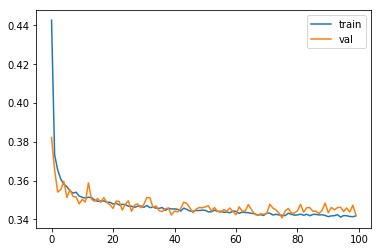

In [20]:
plt.plot(history_std.history['loss'],label='train')
plt.plot(history_std.history['val_loss'],label='val')
plt.legend()
# plt.savefig('../figures/valid/loss_CNN_Frank_network.pdf')
plt.show()

### RMSE for different combos (grid search :( )

In [21]:
# units = 1024
# batch_size = 256
# epochs = 64
# dropout = 0.2
# # Regularise
# tau = 0.01
# lengthscale = .01______________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# dense_7 (Dense)              (None, 1024)              14336     
# _________________________________________________________________
# lambda_6 (Lambda)            (None, 1024)              0         
# _________________________________________________________________
# dense_8 (Dense)              (None, 1024)              1049600   
# _________________________________________________________________
# lambda_7 (Lambda)            (None, 1024)              0         
# _________________________________________________________________
# dense_9 (Dense)              (None, 1024)              1049600   
# _________________________________________________________________
# lambda_8 (Lambda)            (None, 1024)              0         
# _________________________________________________________________
# dense_10 (Dense)             (None, 1024)              1049600   
# _________________________________________________________________
# lambda_9 (Lambda)            (None, 1024)              0         
# _________________________________________________________________
# dense_11 (Dense)             (None, 1024)              1049600   
# _________________________________________________________________
# lambda_10 (Lambda)           (None, 1024)              0         
# _________________________________________________________________
# dense_12 (Dense)             (None, 5)                 5125      
# =================================================================
# Total params: 4,217,861
# Trainable params: 4,217,861
# Non-trainable params: 0

preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
preds_denorm = preds * y_data.std(0) + y_data.mean(0)
y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
print(preds_denorm.shape)
rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
print(rmse)
# (9999, 5)
# [336.68266984   2.2697777    2.66103036   2.07316571   2.14066443]

(9999, 5)
[333.404525     2.26160873   2.66270028   2.07649982   2.14495427]


### Validation

In [22]:
# x_data_test, y_data_test = x_data_val, y_data_val #load_data_file(data_file='../test/testing_hela.npy', num_features=num_features)

## Generate samples for validation data
* For each planet sample TxN_ensemble abundances

In [23]:
No_pred = y_data_val.shape[0] # Number of planets to predict over
T=1000 # Number of samples from the network per planet (e.g. 100 different H2O predictions to give a heat map)
PRED = np.zeros((No_pred,N_ensemble,T,y_data_val.shape[-1]))
n = 0

for planet in range(No_pred):
    PRED[planet,n] = np.array([std_model.predict(x_data_val[planet,:].reshape((1,-1))) for _ in range(T)]).squeeze()
    #PRED[planet,n] = np.array([std_model.predict(x_data_te[-1+planet,:].reshape((1,-1,1))).reshape((1,num_features)) for _ in range(T)]).squeeze() #earth?

    if planet % 1000 == 0:
        print(planet,' planet completed')
# predictions_test = pipeline.trees_predict(np.array(x_data_test)[0,:])

0  planet completed
1000  planet completed
2000  planet completed
3000  planet completed
4000  planet completed
5000  planet completed
6000  planet completed
7000  planet completed
8000  planet completed
9000  planet completed


In [24]:
PRED_o = PRED[:]

In [25]:
PRED = PRED_o[:,:].reshape((No_pred,-1,y_data_val.shape[-1]))

# Plots: predictions vs true for validation
* Red line is the y = x just to show if there is correlation

In [26]:
# un-normalise

PRED_un = PRED * y_data.std(0)[:num_features] + y_data.mean(0)[:num_features]
# y_data_val_un = y_data_val * y_data_tr.std(0)[:num_features] +y_data_tr.mean(0)[:num_features]

### For Earth append to end of validation and look at the last value for the validation

In [27]:
names =  ["T (K)", "H2O", "HCN", "NH3", "kappa0"]
ranges =  [[0, 3000], [-13, 0], [-13, 0], [-13, 0], [-13, 0]],
colors  = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8"]

In [28]:
from sklearn import metrics

R2:  0.7680049371360158


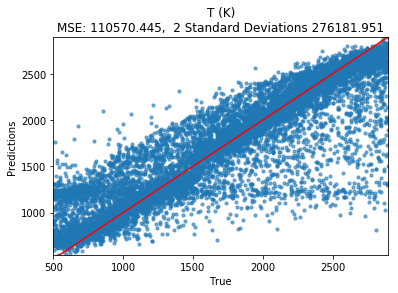

R2:  0.6366994855883898


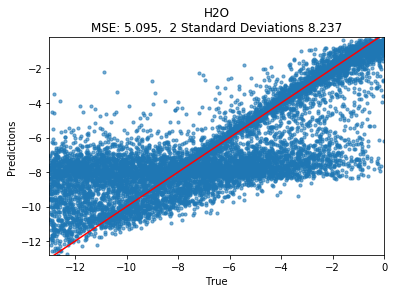

R2:  0.49888643243651565


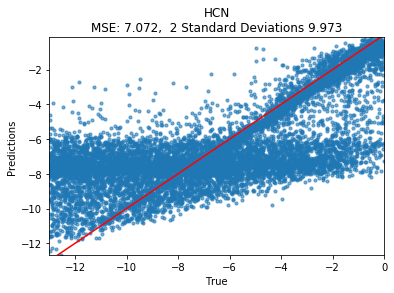

R2:  0.7333944710322444


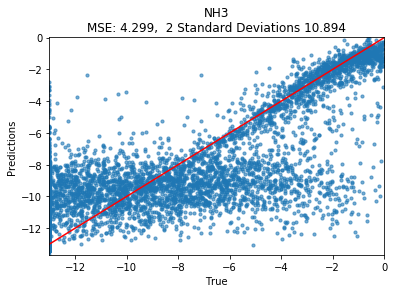

R2:  0.7524508000277015


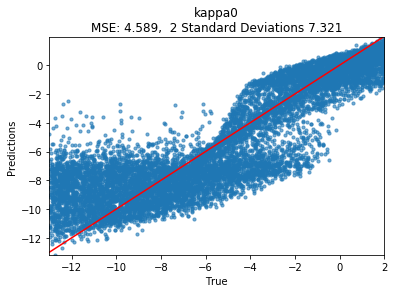

In [31]:
yyy = [-20,20] # This is just defining y = x
minx = np.min(y_data_val[:No_pred,:])
maxx = np.max(y_data_val[:No_pred,:])
miny = np.min(PRED.mean(1)[:,:])
maxy = np.max(PRED.mean(1)[:,:])
for mol in range(y_data_tr.shape[-1]):
    plt.title(names[mol])
    plt.ylabel('Predictions')
    plt.xlabel('True')
    minx = np.min(y_data_val_un[:No_pred,mol])
    maxx = np.max(y_data_val_un[:No_pred,mol])
    miny = np.min(PRED_un.mean(1)[:,mol])
    maxy = np.max(PRED_un.mean(1)[:,mol])
    plt.xlim([minx,maxx])
    plt.ylim([miny,maxy])
    plt.scatter(y_data_val_un[:No_pred,mol],PRED_un.mean(1)[:,mol],s=10,alpha=0.6)
    yyy = [min(miny,minx),max(maxx,maxy)]
    plt.plot(yyy,yyy,'r')
    
#     print('For ',No_pred,' test planets:\n')
    # MSE: 
    MSE = np.mean((y_data_val_un[:No_pred,mol]  - PRED_un.mean(1)[:,mol])**2)
    sig = np.std((y_data_val_un[:No_pred,mol]  - PRED_un.mean(1)[:,mol])**2)
#     print(names[mol] + ' MSE: ',MSE, ' 2 Standard Deviations on MSE: ',2*sig)
    plt.title(names[mol] + '\nMSE: %.3f,  2 Standard Deviations %.3f' % (MSE,sig))
    
    print('R2: ',metrics.r2_score(y_data_val_un[:No_pred,mol], PRED_un.mean(1)[:,mol]))
#     plt.savefig('./figures/valid/NN_validation'+names[mol]+'pred_vs_true.pdf')
    plt.show()

In [31]:

from scipy.signal import butter, lfilter
from scipy.signal import freqs

def butter_lowpass(cutOff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutOff / nyq
    b, a = butter(order, normalCutoff, btype='low', analog = True)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = scipy.signal.lfilter(b, a, data)
    return y

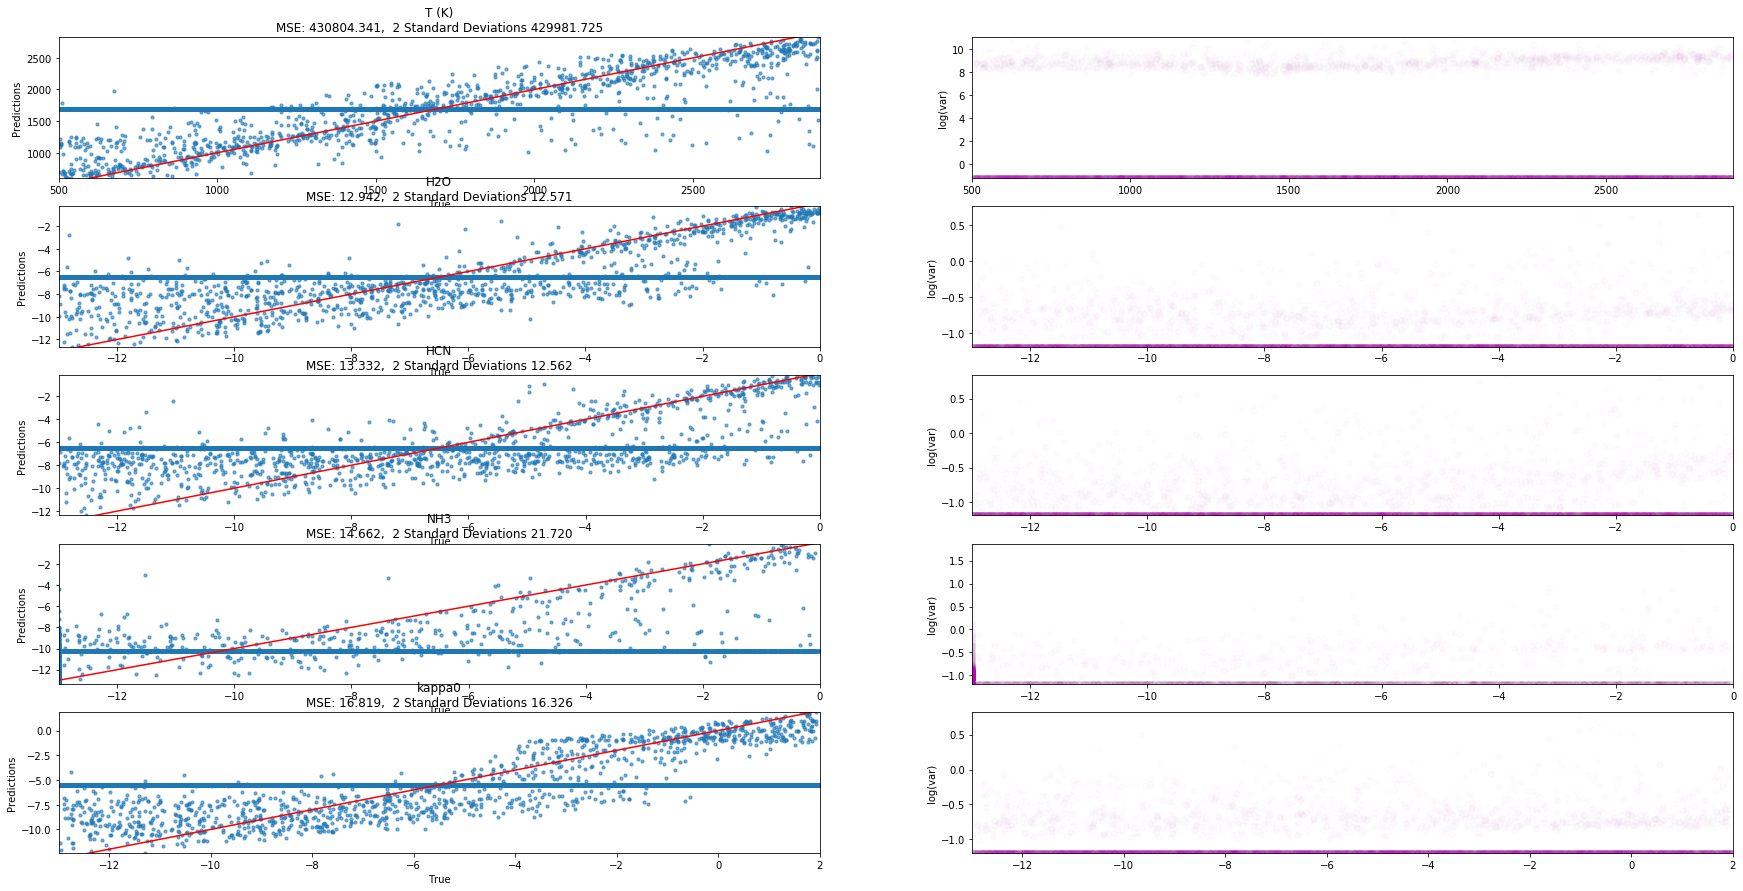

In [52]:
import scipy.signal

yyy = [-20,20] # This is just defining y = x
minx = np.min(y_data_val[:No_pred,:])
maxx = np.max(y_data_val[:No_pred,:])
miny = np.min(PRED.mean(1)[:,:])
maxy = np.max(PRED.mean(1)[:,:])
# fig, axes = plt.subplots( [y_data_tr.shape[-1],2,] figsize=(45, 5), sharex=True, sharey=True)
plt.figure(figsize=(30, 15))
n = 1
for mol in range(y_data_tr.shape[-1]):
    plt.subplot(y_data_tr.shape[-1],2,n)
    plt.title(names[mol])
    plt.ylabel('Predictions')
    plt.xlabel('True')
    minx = np.min(y_data_val_un[:No_pred,mol])
    maxx = np.max(y_data_val_un[:No_pred,mol])
    miny = np.min(PRED_un.mean(1)[:,mol])
    maxy = np.max(PRED_un.mean(1)[:,mol])
    plt.xlim([minx,maxx])
    plt.ylim([miny,maxy])
#     plt.scatter(y_data_val_un[:No_pred,mol],PRED_un.mean(1)[:,mol],s=10,alpha=0.6)
    color = '#CC6600'
    # Sort so that they are in order to plot:
    true, pred = zip(*sorted(zip(y_data_val_un[:No_pred,mol],PRED_un.mean(1)[:,mol])))
#     # Smooth with filter
#     var = butter_lowpass_filter(var, cutoff=0.5, fs=0.5, order=5)
    var = PRED_un.var(1)[:,mol] #TO DO VARIANCE WITH TAU+(1/ bnn.tau )
    true, pred, var = zip(*sorted(zip(y_data_val_un[:No_pred,mol],PRED_un.mean(1)[:,mol],var)))
#     plt.plot(true, pred + 2*np.sqrt(var), '--', color=color,alpha=0.1)
#     plt.plot(true, pred - 2*np.sqrt(var), '--', color=color,alpha=0.1)
#     plt.plot(true, pred, color='k', lw=2)
    plt.scatter(true,pred,s=10,alpha=0.6)
#     plt.scatter(true)
    yyy = [min(miny,minx),max(maxx,maxy)]
    plt.plot(yyy,yyy,'r')
    
#     print('For ',No_pred,' test planets:\n')
    # MSE: 
    MSE = np.mean((y_data_val_un[:No_pred,mol]  - PRED_un.mean(1)[:,mol])**2)
    sig = np.std((y_data_val_un[:No_pred,mol]  - PRED_un.mean(1)[:,mol])**2)
#     print(names[mol] + ' MSE: ',MSE, ' 2 Standard Deviations on MSE: ',2*sig)
    plt.title(names[mol] + '\nMSE: %.3f,  2 Standard Deviations %.3f' % (MSE,sig))
    plt.subplot(y_data_tr.shape[-1],2,n+1)
    plt.scatter(true,np.log(var),alpha=0.01,color = 'm')
    plt.ylim([np.min(np.log(var)),np.max(np.log(var))])
    plt.ylabel('log(var)')
    plt.xlim([minx,maxx])
    n+= 2
#     plt.savefig('./figures/valid/NN_validation'+names[mol]+'pred_vs_true.pdf')
plt.show()

## HELA PLOTTING FUNCTION

In [32]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn import metrics, neighbors
from sklearn.preprocessing import MinMaxScaler


def predicted_vs_real(y_real, y_pred, names, ranges):
    
    num_plots = y_pred.shape[1]
    num_plot_rows = int(np.sqrt(num_plots))
    num_plot_cols = (num_plots - 1) // num_plot_rows + 1
    
    fig, axes = plt.subplots(num_plot_rows, num_plot_cols,
                             figsize=(5*num_plot_cols, 5*num_plot_rows))
    
    for dim, (ax, name_i, range_i) in enumerate(zip(axes.ravel(), names, ranges)):
        
        current_real = y_real[:, dim]
        current_pred = y_pred[:, dim]
        
        r2 = metrics.r2_score(current_real, current_pred)
        label = "$R^2 = {:.3f}$".format(r2)
        ax.plot(current_real, current_pred, '.', label=label)
        
        ax.plot(range_i, range_i, '--', linewidth=3, color="C3")
        
        ax.axis("equal")
        ax.grid()
        ax.set_xlim(range_i)
        ax.set_ylim(range_i)
        ax.set_xlabel("Real {}".format(name_i), fontsize=18)
        ax.set_ylabel("Predicted {}".format(name_i), fontsize=18)
        ax.legend(loc="upper left", fontsize=14)
    
    fig.tight_layout()
    return fig


def feature_importances(forests, names, colors):
    
    num_plots = len(forests)
    num_plot_rows = (num_plots - 1) // 2 + 1
    num_plot_cols = 2
    
    fig, axes = plt.subplots(num_plot_rows, num_plot_cols,
                             figsize=(15, 3.5*num_plot_rows))
    
    for ax, forest_i, name_i, color_i in zip(axes.ravel(), forests, names, colors):
        ax.bar(np.arange(len(forest_i.feature_importances_)), forest_i.feature_importances_,
               label="Importance for {}".format(name_i),
               width=0.4, color=color_i)
        ax.set_xlabel("Feature index", fontsize=18)
        ax.legend(fontsize=16)
        ax.grid()
    
    fig.tight_layout()
    return fig


def posterior_matrix(estimations, y, names, ranges, colors, soft_colors=None):
    
    cmaps = [LinearSegmentedColormap.from_list("MyReds", [(1, 1, 1), c], N=256)
             for c in colors]
    
    ranges = np.array(ranges)
    
    if soft_colors is None:
        soft_colors = colors
    
    num_dims = estimations.shape[1]
    
    fig, axes = plt.subplots(nrows=num_dims, ncols=num_dims,
                             figsize=(2 * num_dims, 2 * num_dims))
    fig.subplots_adjust(left=0.07, right=1-0.05,
                        bottom=0.07, top=1-0.05,
                        hspace=0.05, wspace=0.05)
    
    for ax, dims in zip(axes.flat, product(range(num_dims), range(num_dims))):
        dims = list(dims[::-1])
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.title.set_visible(False)
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
            ax.yaxis.set_visible(True)
            if names is not None:
                ax.set_ylabel(names[dims[1]], fontsize=18)
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
            ax.yaxis.set_visible(True)
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
            ax.xaxis.set_visible(True)
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')
            ax.xaxis.set_visible(True)
            if names is not None:
                ax.set_xlabel(names[dims[0]], fontsize=18)
        if ax.is_first_col() and ax.is_first_row():
            ax.yaxis.set_visible(False)
            ax.set_ylabel("")
        if ax.is_last_col() and ax.is_last_row():
            ax.yaxis.set_visible(False)
        
        if dims[0] < dims[1]:
            locations, kd_probs, *_ = _kernel_density_joint(estimations[:, dims], ranges[dims])
            ax.contour(locations[0], locations[1],
                       kd_probs,
                       colors=colors[dims[0]],
                       linewidths=0.5
                       # 'copper', # 'hot', 'magma' ('copper' with white background)
                      )
            histogram, grid_x, grid_y = _histogram(estimations[:, dims], ranges[dims])
            ax.pcolormesh(grid_x, grid_y, histogram, cmap=cmaps[dims[0]])
            
            expected = np.median(estimations[:, dims], axis=0)
            ax.plot([expected[0], expected[0]], [ranges[dims[1]][0], ranges[dims[1]][1]], '-', linewidth=1, color='#222222')
            ax.plot([ranges[dims[0]][0], ranges[dims[0]][1]], [expected[1], expected[1]], '-', linewidth=1, color='#222222')
            ax.plot(expected[0], expected[1], '.', color='#222222')
            ax.axis('normal')
            if y is not None:
                real = y[dims]
                ax.plot(real[0], real[1], '*', markersize=10, color='#FF0000')
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     ranges[dims[1]][0], ranges[dims[1]][1]])
        elif dims[0] > dims[1]:
            ax.plot(estimations[:, dims[0]], estimations[:, dims[1]], '.', color=soft_colors[dims[1]])
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     ranges[dims[1]][0], ranges[dims[1]][1]])
        else:
            histogram, bins = _histogram(estimations[:, dims[:1]], ranges=ranges[dims[:1]])
            ax.bar(bins[:-1], histogram, color=soft_colors[dims[0]], width=bins[1]-bins[0])
            
            kd_probs = histogram
            expected = np.median(estimations[:, dims[0]])
            ax.plot([expected, expected], [0, 1.1 * kd_probs.max()], '-', linewidth=1, color='#222222')
            
            if y is not None:
                real = y[dims[0]]
                ax.plot([real, real], [0, kd_probs.max()], 'r-')
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     0, 1.1 * kd_probs.max()])
    
    # fig.tight_layout(pad=0)
    return fig


def _min_max_scaler(ranges, feature_range=(0, 100)):
    res = MinMaxScaler()
    res.data_max_ = ranges[:, 1]
    res.data_min_ = ranges[:, 0]
    res.data_range_ = res.data_max_ - res.data_min_
    res.scale_ = (feature_range[1] - feature_range[0]) / (ranges[:, 1] - ranges[:, 0])
    res.min_ = -res.scale_ * res.data_min_
    res.n_samples_seen_ = 1
    res.feature_range = feature_range
    return res


def _kernel_density_joint(estimations, ranges, bandwidth=1/25):
    
    ndims = len(ranges)
    
    scaler = _min_max_scaler(ranges, feature_range=(0, 100))
    
    bandwidth = bandwidth * 100
    # step = 1.0
    
    kd = neighbors.KernelDensity(bandwidth=bandwidth).fit(scaler.transform(estimations))
    locations1d = np.arange(0, 100, 1)
    locations = np.reshape(np.meshgrid(*[locations1d] * ndims), (ndims, -1)).T
    kd_probs = np.exp(kd.score_samples(locations))
    
    shape = (ndims,) + (len(locations1d),) * ndims
    locations = scaler.inverse_transform(locations)
    locations = np.reshape(locations.T, shape)
    kd_probs = np.reshape(kd_probs, shape[1:])
    return locations, kd_probs, kd


def _histogram(estimations, ranges, bins=20):
    
    if len(ranges) == 1:
        histogram, edges = np.histogram(estimations[:, 0], bins=bins, range=ranges[0])
        return histogram, edges
    
    if len(ranges) == 2:
        histogram, xedges, yedges = np.histogram2d(estimations[:, 0], estimations[:, 1], bins=bins, range=ranges)
        grid_x, grid_y = np.meshgrid(xedges, yedges)
        return histogram.T, grid_x, grid_y, 

## Go back to original scale: (Un-normalise)

In [50]:
# un-normalise
# PRED_un = PRED * y_data.std(0)[:num_features] +y_data.mean(0)[:num_features]
# y_data_val_un = y_data_val * y_data.std(0)[:num_features] +y_data.mean(0)[:num_features]

## Plot posteriors

In [37]:
ll_list = []
for i in range(1000):
    o = bnn.evaluate(x_data_val[i].reshape((1,-1)),y_data_tr[i].reshape((1,-1)))
#     print(i,':  ',o)
    ll_list.append(o)
    
print('Best planet: ', np.argmax(ll_list))

/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


KeyboardInterrupt: 

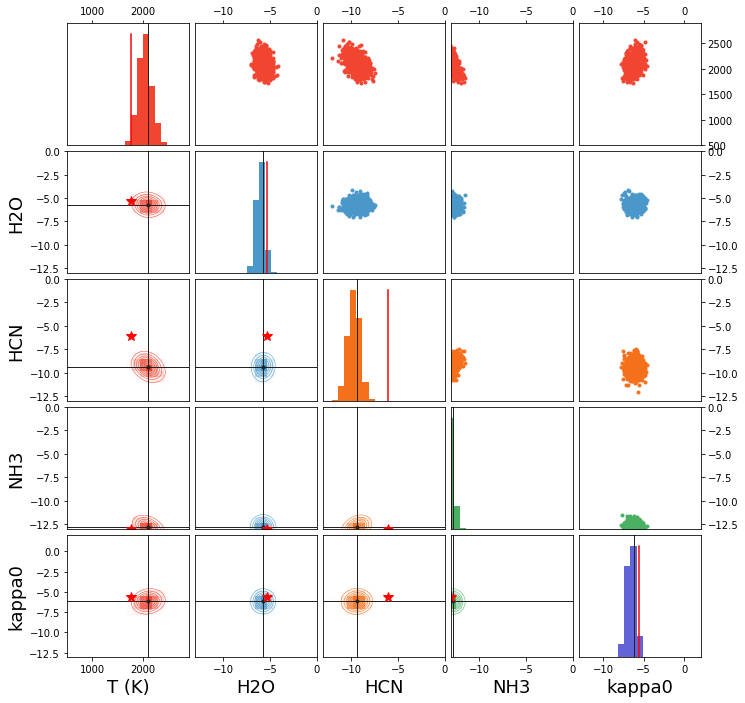

In [33]:
planet_id = 1; #101#50, 71, 11, 101, 50 51! 889! 0 is earth if in other cell -1 is selected
num_features = 12
#delta = 0.05
ranges=[[x, y] for x, y in zip(y_data_val_un.min(0), y_data_val_un.max(0))]
# FOR ZOOMED IN UNCOMMENT LINE BELOW
#ranges=[[x, y] for x, y in zip(PRED_un[planet_id,:,:num_features].min(0), PRED_un[planet_id,:,:num_features].max(0))]
# [[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, 1],[0, 1]]
# names =  ["H20", "CO2", "O2", "N2", "CH4", "C2H6", "O3", "N2O", "NH3", "SO2", "C25H28N6O7", "?"]
#names =  ["H20", "CO2", "O2", "N2", "CH4"]
#colors = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8"]#, "#F14532", "#4a98c9", "#f4701b", 
#           "#4bb062", "#6363d8","#4bb062", "#6363d8","#4a98c9", "#f4701b"]
# colors = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8", "#F14532", "#4a98c9", "#f4701b", 
#            "#4bb062", "#6363d8","#4bb062", "#6363d8","#4a98c9", "#f4701b"]
posterior_matrix(PRED_un[planet_id,:,:num_features], y_data_val_un[planet_id,:num_features], names, ranges, colors, soft_colors=None)
# plt.savefig('./figures/valid/BNN_posterior_planet_'+str(planet_id)+'.pdf')
plt.show()

In [40]:
PRED_un.shape

(9999, 50, 5)

In [ ]:
PRED_un[planet_id,:,:num_features]